# Twitter Sentiment Analysis
Abrar Habib, CSc447

In [24]:
import pandas as pd
import numpy as np
import nltk
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from concurrent.futures import ProcessPoolExecutor
from sklearn.metrics import classification_report, accuracy_score

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/abrar/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/abrar/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/abrar/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/abrar/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/abrar/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]   

True

In [25]:
# Limiting to only the first 1000 rows because there are a lot of tweets.
header = ["tweet_id", "topic", "sentiment", "text"]
nRowsRead = None
file_name = './data/twitter_training.csv' if not os.path.exists('./data/twitter_training_processed.csv') else './data/twitter_training_processed.csv'
df = pd.read_csv('./data/twitter_training.csv', delimiter=',', nrows=nRowsRead, header=None, names=header)
df['text'] = df['text'].fillna("")
df

,tweet_id,topic,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


Load testing dataset

In [26]:
header = ["tweet_id", "topic", "sentiment", "text"]
nRowsRead = None
file_name = './data/twitter_validation.csv'
df_val = pd.read_csv('./data/twitter_validation.csv', delimiter=',', nrows=nRowsRead, header=None, names=header)
df_val['text'] = df_val['text'].fillna("")
df_val

,tweet_id,topic,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


## Preprocess text

Side note: Wanted to see what the stop words were. Pretty interesting to see certain words that are considered stop words. I would have thought the words "wouldn't" and "won't" would be meaningful to a sentence, but this library considers them to be stop words.

In [27]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [28]:
def preprocess_text(text: str) -> str:
    # tokenize text
    tokens = word_tokenize(text.lower())
    
    # remove stopwords
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    
    # lemmatize text
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # join the tokens back into a string
    preprocessed_text = " ".join(lemmatized_tokens)
    
    return preprocessed_text

# apply the preprocess_text function to the 'text' column

def process_chunk(chunk, func):
    """Process a chunk of the DataFrame column with the given function."""
    return chunk.apply(func)

def parallel_apply(df, func, column_name, num_processes):
    """
    Apply a function to a specific column of a DataFrame in parallel.

    Args:
    - df (pd.DataFrame): The DataFrame to process.
    - func (callable): The function to apply to each element of the column.
    - column_name (str): The name of the column to process.
    - num_processes (int): Number of processes to use.

    Returns:
    - pd.Series: The processed column as a Series.
    """
    # Split the column into chunks
    chunks = np.array_split(df[column_name], num_processes)

    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        # Apply the function to each chunk in parallel
        processed_chunks = list(executor.map(process_chunk, chunks, [func] * len(chunks)))

    # Concatenate processed chunks back into a single Series
    return pd.concat(processed_chunks)

# Example Usage
if not os.path.exists('./data/twitter_training_processed.csv'):
    df['processed_text'] = parallel_apply(df, preprocess_text, 'text', num_processes=8)

In [29]:
if not os.path.exists('./data/twitter_training_processed.csv'):
    df.to_csv('./data/twitter_training_processed.csv', index=False)

## Create model and train 

In [30]:
# Split the data into training and validation sets

X_train = df.drop(columns=['sentiment'])
y_train = df['sentiment']

X_val = df_val.drop(columns=['sentiment'])
y_val = df_val['sentiment']

In [31]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), )

# Fit and transform the vectorizer on the training data
X_train_vectorized = vectorizer.fit_transform(X_train['text'])

# Transform the validation set
X_val_vectorized = vectorizer.transform(X_val['text'])

In [32]:
# Initialize the Multinomial Naive Bayes classifier
clf = MultinomialNB()

# Fit the classifier
clf.fit(X_train_vectorized, y_train)

# Predict the labels
y_pred = clf.predict(X_val_vectorized)

# Evaluate the classifier
print(classification_report(y_val, y_pred))

# Evaluate the accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.4f}')

              precision    recall  f1-score   support

  Irrelevant       1.00      0.80      0.89       172
    Negative       0.89      0.99      0.94       266
     Neutral       0.98      0.94      0.96       285
    Positive       0.92      0.98      0.95       277

    accuracy                           0.94      1000
   macro avg       0.95      0.93      0.93      1000
weighted avg       0.94      0.94      0.94      1000

Accuracy: 0.9400


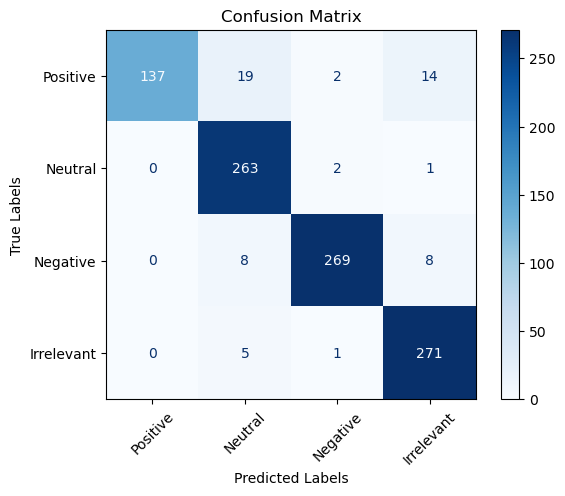

In [37]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Define the class names (assumed they are the unique values in y_train/y_val)
class_names = y_train.unique()  # This should match ['irrelevant', 'neutral', 'positive', 'negative']

# Option 1: Use sklearn's ConfusionMatrixDisplay for labeled display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig("./figures/confusion_matrix.png")
plt.show()

## Let's test the model ourselves

In [34]:
def get_sentiment(text: str) -> str:
    # Preprocess the text
    preprocessed_text = preprocess_text(text)
    
    # Vectorize the preprocessed text
    text_vectorized = vectorizer.transform([preprocessed_text])
    
    # Predict the sentiment
    sentiment = clf.predict(text_vectorized)[0]
    
    return sentiment

# Example Usage
text = "I don't dislike this product"
sentiment = get_sentiment(text)
print(sentiment)


Negative


## Let's get some insight into the data

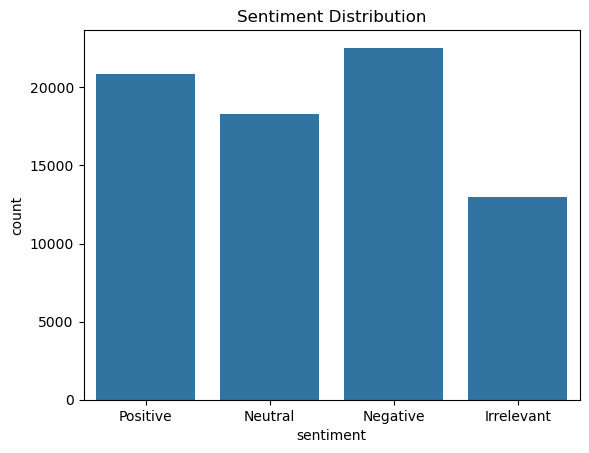

In [38]:
# graph the distribution of the sentiment in the data
sns.countplot(data=df, x='sentiment')
plt.title('Sentiment Distribution')
plt.savefig('./figures/sentiment_distribution.png') 
plt.show()